# Proyecto B Etapa 2 Modelado, Simulación y Optimización

Integrantes:

• Laura Valentina Lara Díaz - 201912967

• Mateo Calderón Rincón - 202213589

• Alejandro lancheros - 202122797

## Implementación del modelo matemático

## Procesamiento de datos

Como el caso que estamos resolviendo emplea distintos tipos de vehículos, que se desplazan de forma diferente entre ellos, es necesario definir como se van a registrar las distancias entre los depósitos y los clientes para de esta forma calcular la mejor manera las rutas para que los clientes puedan satisfacer sus demandas teniendo en cuenta los vehículos. De acuerdo con la información suministrada se tienen dos tipos de vehículos para realizar las entregas, camionetas y drones, los cuales tienen condiciones distintas, ya que las camionetas dependen totalmente de las carreteras que conectan a esos puntos, mientras que los drones no las necesitan para realizar sus desplazamientos. Adicionalmente, los drones se pueden mover en línea recta, permitiendo que la distancia entre los puntos que se quieran analizar sea calculada de forma diferente a la que se quiere hacer con las camionetas.

Para el calculo de la distancia y tiempo entre los puntos (entiéndanse como depósitos y clientes) para las camionetas, se hace uso del API de OpenRouteService, la cual permite calcular la distancia entre dos puntos basada en los caminos existentes y el tiempo de desplazamiento basado en la información que se tenga. A continuación, se presenta el código empleado para obtener dichos tiempos y distancias basadas en la longitud y latitud de cada punto, estos datos quedan guardados en un archivo JSON que se usará luego para construir los grafos de cada uno de los casos, por lo que sencillamente para cada caso lo que se cambian son los datos que se le pasan al API para el cálculo de los datos. Es importante resaltar que si el API retorna error para calcular algún camino, se considera que no es posible que una camioneta realice el desplazamiento ya que no existen caminos entre estos puntos, por lo que se usan valores altos en estos casos, al igual que cuando se tratan de calcular las diagonales de la matriz (distancia del depósito 1 con el depósito 1), donde también se usan valores altos.

**Aclaración importante:** puede que al momento de probar el siguiente código retorne error, ya que el API al ser gratuita tiene ciertos limites, por lo que en algunos casos al querer correr este código puede que retorne error por lo mencionado anteriormente. 

In [ ]:
import pandas as pd
import requests
import time
import pprint
import json

# === Cargar archivos
clients = pd.read_csv("data-caso1/clients.csv")
depots  = pd.read_csv("data-caso1/depots.csv")

# === Coordenadas
nodes = {
    0: (
        depots.loc[0, "Longitude"],
        depots.loc[0, "Latitude"]
    )
}
for _, row in clients.iterrows():
    node_id = int(row["ClientID"])
    coord   = (row["Longitude"], row["Latitude"])
    nodes[node_id] = coord

# === Configuración de API
api_key = '5b3ce3597851110001cf6248f4bace05742cd52a0f6b877ce5d52bffe229f05a5f3132ac87cef6d3'
headers = {
    'Authorization': api_key,
    'Content-Type': 'application/json'
}
url = 'https://api.openrouteservice.org/v2/directions/driving-car'

# === Crear grafo (matriz de distancias y tiempos)
grafo = {}

for i, coords_i in nodes.items():
    grafo[i] = {}
    for j, coords_j in nodes.items():
        if i == j:
            # Sin desplazamiento: valor "infinito"
            grafo[i][j] = (999.0, 999.0)
            continue

        params = {
            'start': f"{coords_i[0]},{coords_i[1]}",
            'end':   f"{coords_j[0]},{coords_j[1]}"
        }

        response = requests.get(url, headers=headers, params=params)
        time.sleep(1.6)  # para no sobrepasar el rate-limit

        if response.status_code == 200:
            seg   = response.json()['features'][0]['properties']['segments'][0]
            dist  = round(seg['distance'] / 1000, 2)
            tiem  = round(seg['duration'] / 60, 2)
            if dist == 0.0: dist = 999.0
            if tiem == 0.0: tiem = 999.0
            grafo[i][j] = (dist, tiem)

        elif response.status_code == 404:
            # ruta no encontrada
            grafo[i][j] = (999.0, 999.0)

        else:
            # otros errores HTTP
            print(f"Error {response.status_code}: {response.text}")
            grafo[i][j] = (999.0, 999.0)


# === Guardar en JSON
with open("distancias-tiempo-api-carro-1.json", "w") as f:
    json.dump(grafo, f, indent=2)


Este código generó 3 archivos JSON distintos, cada uno para un caso distinto, los archivos reciben los nombres "distancias-tiempo-api-carro-#" siendo # el número del caso para el cuál se están calculando los datos.


Esta imagen muestra la composición de los archivos:

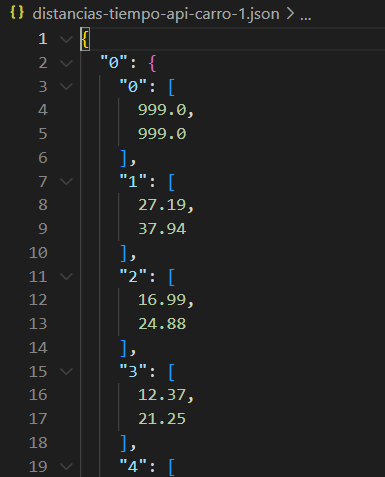

Ahora, es necesario implementar un código que tome estos JSON con los resultados del API y permita generar un grafo, esto con el objetivo de tener los datos listos para entregarselos al modelo y que de esa forma pueda solucionarse el problema. 

El código siguiente es el que toma los archivos JSON y genera grafos con las distancias y tiempos para trayecto. Esta es la implementación que se usó en cada uno de los casos:

In [1]:
import json
import pprint

# Cargar el archivo JSON 
with open('distancias-tiempo-api-carro-1.json', 'r') as f:
    data = json.load(f)

# Reconstruir grafo
grafo1 = {}
for origen_str, destinos in data.items():
    origen = int(origen_str)
    grafo1[origen] = {}
    for destino_str, valores in destinos.items():
        destino = int(destino_str)

        dist, tiem = valores

        if dist == 0.0: dist = 999.0
        if tiem == 0.0: tiem = 999.0
        grafo1[origen][destino] = (dist, tiem)


Esta es la estructura del grafo resultante del código anterior, el primer valor contiene la distancia en km y la segunda el tiempo en minutos

In [2]:
print(grafo1)

{0: {0: (999.0, 999.0), 1: (27.19, 37.94), 2: (16.99, 24.88), 3: (12.37, 21.25), 4: (26.7, 37.46), 5: (22.64, 37.66), 6: (19.65, 30.32), 7: (25.02, 41.42), 8: (23.89, 39.78), 9: (30.67, 45.27), 10: (33.86, 48.42), 11: (33.49, 45.98), 12: (15.87, 25.26), 13: (21.66, 32.79), 14: (10.36, 18.26), 15: (26.79, 37.02), 16: (33.91, 49.26), 17: (26.61, 40.59), 18: (19.87, 34.03), 19: (20.93, 29.42), 20: (13.14, 21.99), 21: (27.84, 38.78), 22: (24.41, 33.01), 23: (11.34, 19.85), 24: (30.87, 45.29)}, 1: {0: (30.96, 40.45), 1: (999.0, 999.0), 2: (14.29, 20.42), 3: (19.44, 24.53), 4: (1.13, 3.0), 5: (12.5, 18.04), 6: (11.32, 18.15), 7: (17.81, 34.15), 8: (13.75, 20.17), 9: (7.51, 11.23), 10: (7.39, 12.68), 11: (10.33, 11.93), 12: (25.81, 31.21), 13: (8.3, 14.06), 14: (20.31, 24.21), 15: (1.29, 2.81), 16: (7.44, 13.51), 17: (4.49, 10.82), 18: (9.84, 16.34), 19: (14.97, 23.16), 20: (23.09, 27.94), 21: (21.68, 31.86), 22: (5.38, 8.34), 23: (21.29, 25.8), 24: (4.89, 9.97)}, 2: {0: (18.34, 23.89), 1: (1

Adicionalmente, para calcular las distancias y tiempos que tomarían los drones en desplazarse entre los distintos puntos, debemos recordar que estos se mueven en línea recta se hizo uso de la función de Haversine, la cual permite calcular la distancia más corta entre dos puntos en la superficie de una esfera, en este caso la Tierra, para ello se usan las coordenadas proporcionadas para cada uno de los depósitos y clientes (latitud y longitud):

$$
d = 2r \cdot \arcsin\left( 
\sqrt{ 
\sin^2\left( \frac{\phi_2 - \phi_1}{2} \right) 
+ \cos(\phi_1) \cos(\phi_2) \sin^2\left( \frac{\lambda_2 - \lambda_1}{2} \right) 
} 
\right)
$$

Esta es la implementación que toma los datos de los casos 2 y 3, y en base a ello calcula las distancias y el tiempo usando la función anteriormente descrita, a continuación, se muestra la implementación usada:

In [3]:
import math
import pandas as pd

# Función para calcular la distancia entre dos puntos geográficos usando longitud y latitud
def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    
    R = 6371.0  # Radio de la Tierra en km
    
    # Grados a radianes
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    # Fórmula matemática
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c
    return distance

# Cargar datos de clientes y depósito
clients = pd.read_csv("data-caso2/clients.csv")
depots = pd.read_csv("data-caso2/depots.csv")

# Crear un diccionario de nodos con coordenadas
nodes = {}

# Agregar el depósito como nodo central
for _, row in depots.iterrows():
    nodes[row["LocationID"]] = (row["Longitude"], row["Latitude"])

# Agregar los clientes como nodos
for _, row in clients.iterrows():
    nodes[row["LocationID"]] = (row["Longitude"], row["Latitude"])

# Cargar datos de vehículos
vehicles = pd.read_csv("data-caso2/vehicles.csv")

# Filtrar solo los vehículos cuyo Type sea 'drone'
drones = vehicles[vehicles["Type"] == "drone"]

# Crear un diccionario para almacenar las velocidades de los drones
drone_speeds = dict(zip(drones["VehicleID"], drones["Speed"]))

# Diccionario para almacenar el grafo de distancias y tiempos para drones
graphdron = {}

for i, coord_i in nodes.items():
    graphdron[i] = {}  # Inicializar el nodo en el grafo
    for j, coord_j in nodes.items():
        if i == j:
            # Si son el mismo nodo, asignar valores grandes
            graphdron[i][j] = (999, 999)  # Distancia y tiempo grandes
        else:
            # Calcular la distancia usando la fórmula de Haversine
            distance_km = haversine(coord_i, coord_j)
            # Calcular el tiempo promedio para drones (usando la velocidad promedio de los drones)
            if len(drone_speeds) > 0:
                avg_speed_km_min = sum(float(speed) for speed in drone_speeds.values() if speed != "N/A") / (60.0 * len(drone_speeds))
                duration_min = distance_km / avg_speed_km_min
                graphdron[i][j] = (round(distance_km, 3), round(duration_min, 3))
            else:
                # Si no hay velocidad disponible, asignar valores grandes
                graphdron[i][j] = (999, 999)


Este es el grafo que arroja el código anterior después de usar la función de Haversine para el calculo de distancias y tiempos para los drones:

In [4]:
pprint.pprint(graphdron)

{np.float64(0.0): {np.float64(0.0): (999, 999),
                   1: (2.646, 1.176),
                   2: (0.894, 0.397),
                   3: (5.297, 2.354),
                   4: (2.712, 1.205),
                   5: (3.247, 1.443),
                   6: (2.853, 1.268),
                   7: (2.286, 1.016),
                   8: (3.701, 1.645),
                   10: (3.017, 1.341),
                   11: (4.091, 1.818),
                   12: (1.279, 0.569),
                   13: (1.612, 0.716),
                   14: (3.708, 1.648),
                   90: (2.164, 0.962)},
 1: {np.float64(0.0): (2.646, 1.176),
     1: (999, 999),
     2: (3.38, 1.502),
     3: (6.25, 2.778),
     4: (3.391, 1.507),
     5: (1.741, 0.774),
     6: (3.463, 1.539),
     7: (4.763, 2.117),
     8: (4.977, 2.212),
     10: (1.335, 0.593),
     11: (5.769, 2.564),
     12: (2.396, 1.065),
     13: (1.573, 0.699),
     14: (2.806, 1.247),
     90: (4.642, 2.063)},
 2: {np.float64(0.0): (0.894, 0.397),


## Resolución del modelo, análisis de resultados y visualización

## Caso 1

Como lo mencionamos en la etapa de procesamiento de datos, tenemos que extraer la información del archivo JSON que contiene las distancias y el tiempo calculados para la camioneta, con el objetivo de formar un grafo que nos ayude a organizar la información para usarla en el modelo. Pero primero es importante definir algo, como en los datos del 'Proyecto Base' en el archivo de vehicles.csv, no tenemos indicado el tipo de vehículo que es cada uno de ellos, hemos decidido dejar a todos los vehículos como camionetas 4x4. 

Por lo tanto, aquí tenemos el código que como se mencionaba anteriormente permite construir el grafo con la distancia (km) y el tiempo (min)

In [5]:
import json

# Cargar el archivo JSON
with open('distancias-tiempo-api.json', 'r') as f:
    data = json.load(f)

# Crear la variable grafo
grafo1 = {}

for origen, destinos in data.items():
    grafo1[int(origen)] = {}
    for destino, valores in destinos.items():
        distancia = valores['distance_km']
        tiempo = valores['time_min']
        if distancia == 0.0:
            distancia = 999.0
        if tiempo == 0.0:
            tiempo = 999.0
        grafo1[int(origen)][int(destino)] = (distancia, tiempo)




A continuación, se incluye la implementación del modelo en pyomo para solucionar el problema teniendo en cuenta que no se consideran ventanas de tiempo ni reabastecimiento:

In [6]:
from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals,
    Objective, Constraint, minimize, SolverFactory
)
import pandas as pd

# Datos 
clients = pd.read_csv("data-caso1/clients.csv")
vehicles = pd.read_csv("data-caso1/vehicles.csv")

clientes = clients["ClientID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = [0] + clientes

demanda = dict(zip(clients["ClientID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))


distancias = {(i,j): grafo1[i][j][0] for i in nodos for j in nodos if i!=j}
tiempos    = {(i,j): grafo1[i][j][1] for i in nodos for j in nodos if i!=j}

# Construcción del modelo 
model = ConcreteModel()

model.N = Set(initialize=nodos)
model.C = Set(initialize=clientes)
model.V = Set(initialize=vehiculos)

model.d = Param(model.C, initialize=demanda) # demanda de los clientes
model.q = Param(model.V, initialize=capacidad) # capacidad de los vehículos
model.dist = Param(model.N, model.N, initialize=distancias, default=1e6)
model.t = Param(model.N, model.N, initialize=tiempos, default=0)

# Costos 
model.Pf = Param(initialize=15000)   # precio combustible por litro
model.Cm = Param(initialize=700)     # costo mantenimiento por km
model.Ce = Param(initialize=0)       # costo eléctrico
model.Ft = Param(initialize=5000)    # tarifa fija por km
model.Cv = Param(initialize=0)       # costo por viaje

# δ_v = 1 para todos los vehículos (todos camionetas)
delta = { v: 1 for v in vehiculos }
model.delta = Param(model.V, initialize=delta)

# Variables
model.x = Var(model.N, model.N, model.V, domain=Binary)
model.u = Var(model.C, model.V, domain=NonNegativeReals)

# Función Objetivo
def obj_custom(m):
    return sum((m.Pf * m.dist[i,j] * m.delta[v] + m.Cm + m.delta[v] * m.Ce + m.Ft + m.Cv * m.t[i,j]) * m.x[i,j,v] for i in m.N for j in m.N for v in m.V if i!=j)
model.obj = Objective(rule=obj_custom, sense=minimize)



# Restricciones
def cliente_una_vez(m, j):
    return sum(m.x[i,j,v] for i in m.N for v in m.V if i!=j) == 1

def cliente_salida(m, j):
    return sum(m.x[j,k,v] for k in m.N for v in m.V if j!=k) == 1

def flujo_cliente(m, j, v):
    return (sum(m.x[i,j,v] for i in m.N if i!=j) - sum(m.x[j,k,v] for k in m.N if k!=j)) == 0

def mtz_rule(m, i, j, v):
    if i!=j:
        return m.u[i,v] + m.d[j] - m.u[j,v] <= m.q[v]*(1 - m.x[i,j,v])
    return Constraint.Skip

def limites_u(m, i, v):
    return (m.d[i], m.u[i,v], m.q[v])

def capacidad_total(m, v):
    return sum(m.d[j]*m.x[i,j,v]
               for i in m.N for j in m.C if i!=j) <= m.q[v]


model.cliente_una_vez = Constraint(model.C, rule=cliente_una_vez)
model.cliente_salida = Constraint(model.C, rule=cliente_salida)
model.flujo = Constraint(model.C, model.V, rule=flujo_cliente)
model.salida_dep = Constraint(model.V, rule=lambda m,v: sum(m.x[0,j,v] for j in m.C) <= 1)
model.entrada_dep = Constraint(model.V, rule=lambda m,v: sum(m.x[i,0,v] for i in m.C) <= 1)
model.mtz = Constraint(model.C, model.C, model.V, rule=mtz_rule)
model.lim_u = Constraint(model.C, model.V, rule=limites_u)
model.cap_total = Constraint(model.V, rule=capacidad_total)

# Solución del modelo
solver = SolverFactory("glpk")
solver.options["tmlim"]  = 60     # segundos máximo
solver.options["mipgap"] = 0.05   # gap 5%
results = solver.solve(model, tee=True)

print("Status:     ", results.solver.status)
print("Termination:", results.solver.termination_condition)
print("Obj. value: ", model.obj())

# Print resultados
print("\n RUTAS ASIGNADAS POR VEHÍCULO:")
for v in model.V:
    rutas, actual, visitados = [], 0, set()
    while True:
        nxt = next(
            (j for j in model.N if j!=actual and model.x[actual,j,v].value>0.5),
            None
        )
        if nxt is None or nxt in visitados:
            break
        rutas.append((actual, nxt))
        visitados.add(nxt)
        actual = nxt
    print(f" Vehículo {v}: {rutas or 'no asignado'}")




GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 60 --mipgap 0.05 --write C:\Users\57314\AppData\Local\Temp\tmp7kaybl4f.glpk.raw
 --wglp C:\Users\57314\AppData\Local\Temp\tmpi7u0jxwd.glpk.glp --cpxlp C:\Users\57314\AppData\Local\Temp\tmpbkc7wbkv.pyomo.lp
Reading problem data from 'C:\Users\57314\AppData\Local\Temp\tmpbkc7wbkv.pyomo.lp'...
C:\Users\57314\AppData\Local\Temp\tmpbkc7wbkv.pyomo.lp:62050: warning: lower bound of variable 'x2' redefined
C:\Users\57314\AppData\Local\Temp\tmpbkc7wbkv.pyomo.lp:62050: warning: upper bound of variable 'x2' redefined
5064 rows, 4992 columns, 37056 non-zeros
4800 integer variables, all of which are binary
66850 lines were read
Writing problem data to 'C:\Users\57314\AppData\Local\Temp\tmpi7u0jxwd.glpk.glp'...
56979 lines were written
GLPK Integer Optimizer 5.0
5064 rows, 4992 columns, 37056 non-zeros
4800 integer variables, all of which are binary
Preprocessing...
4680 rows, 4992 columns, 36672 non-zeros
4800 integ

A continuación, se tiene el código que permite generar el archivo de verificación para este problema, para ello las columnas que se han contemplado para este archivo son las siguientes:

| VehicleId | VehicleType | InitialLoad | RouteSequence| ClientsServed | DemandSatisfied | TotalDistance | TotalTime | Cost |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Identificador único del vehículo, es el mismo valor que se encuentra en el archivo vehicles.csv del caso base | Tipo de vehículo, en este caso todos son trucks | Carga inicial del vehículo al salir del centro de distribución | Secuencia completa de la ruta incluyendo el CD inicial, los clientes (que aparecen de la forma 'COMXX') y los retornos al CD | Número total de clientes atendidos por el vehículo | Lista de demandas satisfechas por cada cliente en el orden visitado | Distancia total recorrida (en km) | Tiempo total de la ruta (en minutos) | Costo total de operación para la ruta (en COP) | 

In [7]:
import pandas as pd

clients_df = pd.read_csv("data-caso1/clients.csv")

records = []
for v in model.V:
    vid       = v
    v_str     = str(v)
    vtype     = "Drone" if v_str.upper().startswith("DRN") else "Truck"
    init_load = float(model.q[v])

    seq        = ["CD"]
    current    = 0
    total_dist = 0.0
    total_time = 0.0
    total_cost = 0.0
    demands    = []

    while True:
        nxt = None
        for j in model.C:
            val = getattr(model.x[current, j, v], "value", None)
            if val is not None and val > 0.5:
                nxt = j
                break
        if nxt is None:
            break

        dist_ij = float(model.dist[current, nxt])
        time_ij = float(model.t[current, nxt])
        cost_ij = (
            model.Pf * dist_ij * model.delta[v]
            + model.Cm
            + model.delta[v] * model.Ce
            + model.Ft
            + model.Cv * time_ij
        )
        total_dist += dist_ij
        total_time += time_ij
        total_cost += cost_ij

        demands.append(int(model.d[nxt]))
        seq.append(f"COM{int(nxt):02d}")
        current = nxt

    ret_val = getattr(model.x[current, 0, v], "value", None)
    if ret_val is not None and ret_val > 0.5:
        dist_ij = float(model.dist[current, 0])
        time_ij = float(model.t[current, 0])
        cost_ij = (model.Pf * dist_ij * model.delta[v] + model.Cm + model.delta[v] * model.Ce + model.Ft + model.Cv * time_ij)
        total_dist += dist_ij
        total_time += time_ij
        total_cost += cost_ij
        seq.append("CD")

    records.append({
        "VehicleId":       vid,
        "VehicleType":     vtype,
        "InitialLoad":     round(init_load, 2),
        "RouteSequence":   "-".join(seq),
        "ClientsServed":   len(demands),
        "DemandSatisfied": "-".join(str(d) for d in demands),
        "TotalDistance":   round(total_dist, 2),
        "TotalTime":       round(total_time, 2),
        "Cost":            round(total_cost, 2),
    })

# Guardar CSV
df_verif = pd.DataFrame(records)
df_verif.to_csv("verification/verification_case1.csv", index=False)


El archivo de verificación fue guardado en el directorio *verification*

In [8]:
import pandas as pd
from IPython.display import display

df = pd.read_csv("verification/verification_case1.csv")
display(df)


,VehicleId,VehicleType,InitialLoad,RouteSequence,ClientsServed,DemandSatisfied,TotalDistance,TotalTime,Cost
0,1,Truck,130.0,CD,0,NaN,0.00,0.00,0.0
1,2,Truck,140.0,CD-COM13-COM04-COM24-COM01-COM15-COM17-COM11-C...,8,21-15-11-13-17-25-17-20,91.73,145.54,1427250.0
2,3,Truck,120.0,CD,0,NaN,0.00,0.00,0.0
3,4,Truck,100.0,CD-COM14-COM23-COM20-COM12-CD,4,15-15-15-12,35.66,59.51,563400.0
4,5,Truck,70.0,CD-COM02-COM07-COM21-COM19-COM03-CD,5,15-17-14-11-12,61.75,122.03,960450.0
5,6,Truck,55.0,CD,0,NaN,0.00,0.00,0.0
6,7,Truck,110.0,CD,0,NaN,0.00,0.00,0.0
7,8,Truck,114.0,CD-COM16-COM10-COM08-COM05-COM06-COM22-COM18-CD,7,10-15-20-20-17-18-12,102.61,166.64,1584750.0


#### Visualización y análisis de resultados

En esta parte del documento, se procederá a realizar diferentes visualizaciones que permitan entender mejor la solución del modelo para este caso y también poder analizarlas en el contexto del problema, para ello se incluirán diferentes graficas.

C:\Users\57314\AppData\Local\Temp\ipykernel_12680\1697471013.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10', len(vehicles))


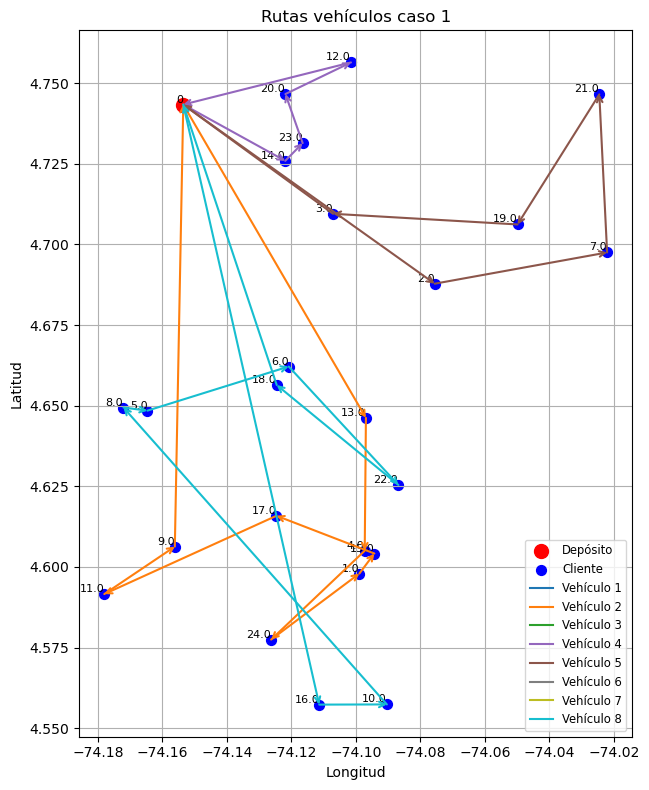

In [9]:
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

clients = pd.read_csv('data-caso1/clients.csv')
depots  = pd.read_csv('data-caso1/depots.csv') 

depot = depots.iloc[0]
coords = { 0: (depot.Longitude, depot.Latitude) }
for _, row in clients.iterrows():
    coords[row.ClientID] = (row.Longitude, row.Latitude)

# Figura
fig, ax = plt.subplots(figsize=(10, 8))
for node, (x, y) in coords.items():
    if node == 0:
        ax.scatter(x, y, c='red', s=100, label='Depósito')
    else:
        label = 'Cliente' if 'Cliente' not in ax.get_legend_handles_labels()[1] else ""
        ax.scatter(x, y, c='blue', s=50, label=label)
    ax.text(x, y, str(node), fontsize=8, ha='right', va='bottom')

# Lineas de ruta
vehicles = list(model.V)
cmap = get_cmap('tab10', len(vehicles))
for idx, v in enumerate(vehicles):
    color = cmap(idx)
    for i in model.N:
        for j in model.N:
            if i != j and model.x[i, j, v].value > 0.5:
                x1, y1 = coords[i]
                x2, y2 = coords[j]
                ax.annotate(
                    '', 
                    xy=(x2, y2), 
                    xytext=(x1, y1),
                    arrowprops=dict(
                        arrowstyle='->',
                        color=color,
                        lw=1.5,
                        shrinkA=0, shrinkB=0
                    ),
                    annotation_clip=False
                )
    ax.plot([], [], color=color, lw=1.5, label=f'Vehículo {v}')


ax.set_title('Rutas vehículos caso 1')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend(loc='best', fontsize='small')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

En la visualización anterior, se puede apreciar la ruta que toman los distintos vehículos sobre el grafo con el objetivo de poder satisfacer las necesidades de los clientes, se puede apreciar que en ningún momento se da un ciclo ni tampoco se llegan a repetir clientes, es importante aclarar que el vehículo 5 no pasa dos veces donde el cliente 3, sino que este inicialmente va al 2 y luego hace un recorrido terminando en el 3, solo que como el recorrido se pinta en línea recta da esa ilusión. Estos recorridos y los vehículos empleados son los mismos que al terminar la ejecución del modelo aparecieron.

In [10]:
import pandas as pd
import folium
from folium import plugins

# Carga de datos
clients = pd.read_csv('data-caso1/clients.csv')
depots  = pd.read_csv('data-caso1/depots.csv')

# Parámetros del mapa
depot = depots.iloc[0]
m = folium.Map(
    location=[depot.Latitude, depot.Longitude],
    zoom_start=12,
    tiles='OpenStreetMap'
)

# Marcadores de depósito y clientes
folium.Marker(
    [depot.Latitude, depot.Longitude],
    popup=f"Depósito {depot.DepotID}",
    icon=folium.Icon(color='red', icon='home')
).add_to(m)

for _, row in clients.iterrows():
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5, color='blue', fill=True, fill_opacity=0.7,
        popup=f"Cliente {row.ClientID}"
    ).add_to(m)

# 4) Colores usados
color_list = [
    'red', 'blue', 'green', 'purple', 'orange',
    'darkred', 'lightred'
]

# Construye de la ruta
for vidx, v in enumerate(model.V):
    color = color_list[vidx % len(color_list)]
    route = [[depot.Latitude, depot.Longitude]]
    

    for i in model.N:
        for j in model.N:
            if i != j and model.x[i, j, v].value > 0.5:
                if j == 0:
                    coord_j = [depot.Latitude, depot.Longitude]
                else:
                    cli = clients[clients.ClientID == j].iloc[0]
                    coord_j = [cli.Latitude, cli.Longitude]
                route.append(coord_j)
    
    line = folium.PolyLine(
        route,
        color=color,
        weight=3,
        opacity=0.8,
        tooltip=f"Vehículo {v}"
    ).add_to(m)
    
    plugins.PolyLineTextPath(
        line,
        '➤                    ',
        repeat=True,
        offset=7,
        attributes={'fill': color, 'font-weight': 'bold', 'font-size': '12'}
    ).add_to(m)

m.save('rutas-caso1.html')



El código anterior, hace algo muy similar al primer código de esta sección ya que permite ver el mapa con el recorrido de los vehículos entre el depósito y los clientes, solo que ahora con el objetivo de que la visualización sea más realista, el trazado ya no se hace sobre un plano sino sobre el mapa correspondiente a las coordenadas que se encontraban en los csv.

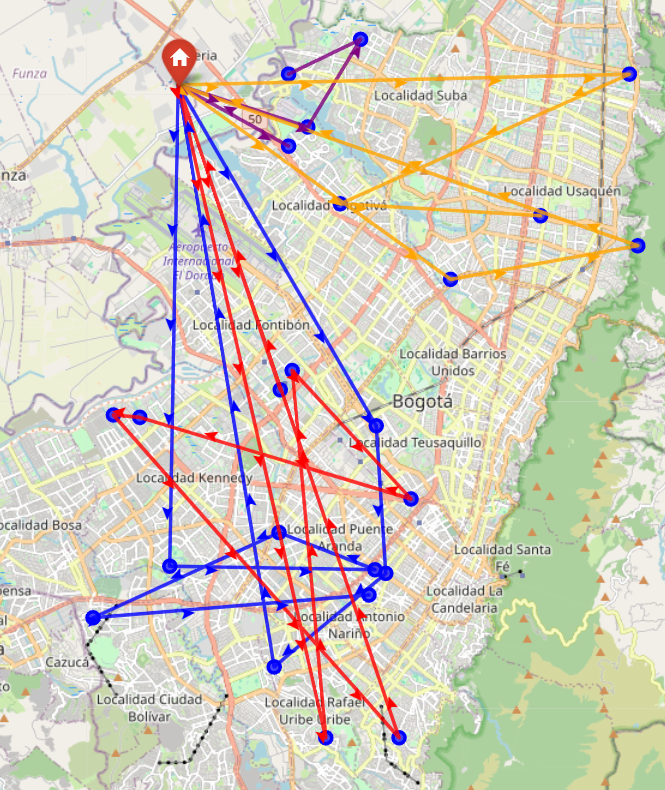

Nuevamente, es importante detallar que el recorrido que se dibuja es solo para ejempificar el orden, ya que como sabemos no es posible hacer recorridos en línea totalmente recta.

Con el objetivo de poder saber completamente si la solución es factible y cumple con el problema, debemos considerar la información del vehículo como lo son sus límites tanto en capacidad como en rango. Y teniendo esto, poder saber si el modelo funciona para ello o si no está respetando estos aspectos fundamentales.

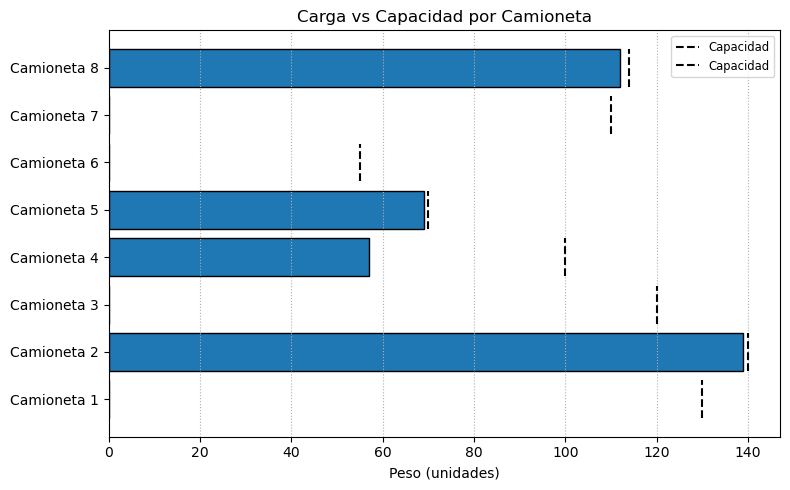

In [11]:
import matplotlib.pyplot as plt

weights = {}
capacities = {}
for v in model.V:
    # clientes atendidos por vehículo v
    visited = [
        j for j in model.C 
        if any(model.x[i, j, v].value > 0.5 for i in model.N if i != j)
    ]
    weights[v]    = sum(model.d[j] for j in visited)
    capacities[v] = model.q[v]

vehicles = list(model.V)
loaded   = [weights[v]    for v in vehicles]
caps     = [capacities[v] for v in vehicles]


y_pos = list(range(len(vehicles)))

# Grafica
fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(y_pos, loaded, edgecolor='black')

# cacapacidad máxima
for idx, cap in enumerate(caps):
    ax.vlines(cap, idx-0.4, idx+0.4,
              linestyles='--', color='black',
              label='_nolegend_' if idx>0 else 'Capacidad')

# Etiquetas y leyenda
ax.set_yticks(y_pos)
ax.set_yticklabels([f'Camioneta {v}' for v in vehicles])
ax.set_xlabel('Peso (unidades)')
ax.set_title('Carga vs Capacidad por Camioneta')
ax.plot([], [], linestyle='--', color='black', label='Capacidad')
ax.legend(loc='best', fontsize='small')
ax.grid(axis='x', linestyle=':')

plt.tight_layout()
plt.show()



La grafica anterior permite ver la relación del peso máximo de capacidad que tiene cada camioneta empleada respecto al peso que cargo para poder llevar las unidades necesitadas por cada cliente que atendió. La barra azul permite ver el peso (en unidades) que repartió, mientras que la línea punteada nos indica el límite máximo que tiene cada camioneta en cuenta a capacidad. 

Todo ello nos permite ver que la solución encontrada en el modelo cumple con esa restricción, ya que vemos que en ningún caso se supera la capacidad máxima del vehículo, en todas las camionetas empleadas se puede ver que la barra azul llega a estar muy cerca de la capacidad máxima (barra punteada) como en el caso de la camioneta 2, la camioneta 5 y la camioneta 8. O incluso puede estar bastante lejos como el caso de la camioneta 4.

Pero lo más importante, es que en ningún caso la barra azul supere a la línea punteada.


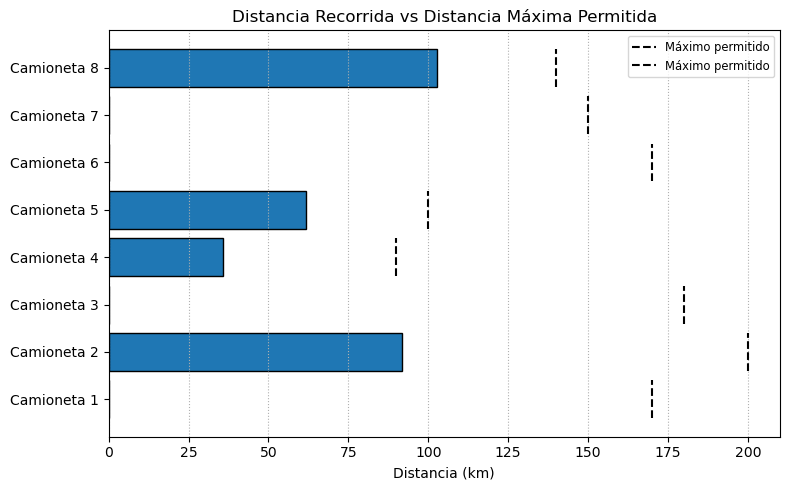

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

vehicles_df = pd.read_csv('data-caso1/vehicles.csv')
max_dist  = dict(zip(vehicles_df['VehicleID'], vehicles_df['Range']))

traveled = {}
for v in model.V:
    traveled[v] = sum(
        model.dist[i, j] * model.x[i, j, v].value
        for i in model.N for j in model.N if i != j
    )

vehicles     = list(model.V)
dist_traveled = [traveled[v] for v in vehicles]
dist_max      = [max_dist[v]  for v in vehicles]

y_pos = list(range(len(vehicles)))

# Dibujo
fig, ax = plt.subplots(figsize=(8, 5))

# Barras horizontales de distancia recorrida
ax.barh(y_pos, dist_traveled, edgecolor='black')

# Líneas punteadas de distancia máxima
for idx, cap in enumerate(dist_max):
    ax.vlines(cap, idx-0.4, idx+0.4,
              linestyles='--', color='black',
              label='_nolegend_' if idx > 0 else 'Máximo permitido')

# Etiquetas y leyenda
ax.set_yticks(y_pos)
ax.set_yticklabels([f'Camioneta {v}' for v in vehicles])
ax.set_xlabel('Distancia (km)')
ax.set_title('Distancia Recorrida vs Distancia Máxima Permitida')
ax.plot([], [], linestyle='--', color='black', label='Máximo permitido')
ax.legend(loc='best', fontsize='small')
ax.grid(axis='x', linestyle=':')

plt.tight_layout()
plt.show()


Esta grafica hace cosas muy similares a la anterior, ya que permite ver la distancia máxima que un vehículo puede recorrer dada la información que se tiene (columna rango en el csv), respecto a la distancia que termine recorriendo para llegar a cada uno de los clientes a los cuales llega. 

Nuevamente, esto permite ver si el modelo está cumpliendo con esa restricción o no; cosa que ocurre perfectamente, ya que en ningún momento la barra azul, que indica la distancia que el vehículo recorrió alcanza o sobrepasa la línea punteada, indicador del rango máximo. En este caso, a diferencia de la gráfica anterior, podemos ver que realmente queda muy lejos del límite, lo cual indica que ninguno de los vehículos quedo cerca de alcanzar el límite máximo de distancia recorrida.

## Caso 2

In [13]:
import json
import pprint

# Cargar el archivo JSON 
with open('distancias-tiempo-api-carro-2.json', 'r') as f:
    data = json.load(f)

# Reconstruir grafo
grafo2 = {}
for origen_str, destinos in data.items():
    origen = int(origen_str)
    grafo2[origen] = {}
    for destino_str, valores in destinos.items():
        destino = int(destino_str)

        dist, tiem = valores

        if dist == 0.0: dist = 999.0
        if tiem == 0.0: tiem = 999.0
        grafo2[origen][destino] = (dist, tiem)




In [14]:
print(grafo2)

{0: {0: (999.0, 999.0), 1: (999.0, 999.0), 2: (999.0, 999.0), 3: (999.0, 999.0), 4: (999.0, 999.0), 5: (999.0, 999.0), 6: (999.0, 999.0), 7: (999.0, 999.0), 8: (999.0, 999.0), 9: (999.0, 999.0), 10: (999.0, 999.0), 11: (999.0, 999.0), 12: (999.0, 999.0), 13: (999.0, 999.0), 14: (999.0, 999.0)}, 1: {0: (999.0, 999.0), 1: (999.0, 999.0), 2: (14.73, 42.21), 3: (9.02, 24.12), 4: (4.3, 12.99), 5: (4.46, 13.49), 6: (999.0, 999.0), 7: (999.0, 999.0), 8: (11.43, 28.93), 9: (11.92, 33.63), 10: (1.58, 4.77), 11: (7.88, 22.33), 12: (999.0, 999.0), 13: (3.95, 11.94), 14: (999.0, 999.0)}, 2: {0: (999.0, 999.0), 1: (14.73, 42.21), 2: (999.0, 999.0), 3: (9.18, 25.02), 4: (10.43, 29.22), 5: (13.35, 37.97), 6: (999.0, 999.0), 7: (999.0, 999.0), 8: (11.59, 29.84), 9: (2.83, 8.63), 10: (16.1, 46.28), 11: (7.81, 22.77), 12: (999.0, 999.0), 13: (13.76, 39.33), 14: (999.0, 999.0)}, 3: {0: (999.0, 999.0), 1: (9.02, 24.12), 2: (9.18, 25.02), 3: (999.0, 999.0), 4: (4.72, 11.13), 5: (7.64, 19.88), 6: (999.0, 99

In [15]:
import math
import pandas as pd

# Función para calcular la distancia entre dos puntos geográficos usando longitud y latitud
def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    
    R = 6371.0  # Radio de la Tierra en km
    
    # Grados a radianes
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    # Fórmula matemática
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c
    return distance

# Cargar datos de clientes y depósito
clients = pd.read_csv("data-caso2/clients.csv")
depots = pd.read_csv("data-caso2/depots.csv")

# Crear un diccionario de nodos con coordenadas
nodes = {}

# Agregar el depósito como nodo central
for _, row in depots.iterrows():
    nodes[row["LocationID"]] = (row["Longitude"], row["Latitude"])

# Agregar los clientes como nodos
for _, row in clients.iterrows():
    nodes[row["LocationID"]] = (row["Longitude"], row["Latitude"])

# Cargar datos de vehículos
vehicles = pd.read_csv("data-caso2/vehicles.csv")

# Filtrar solo los vehículos cuyo Type sea 'drone'
drones = vehicles[vehicles["Type"] == "drone"]

# Crear un diccionario para almacenar las velocidades de los drones
drone_speeds = dict(zip(drones["VehicleID"], drones["Speed"]))

# Diccionario para almacenar los grafos por dron
graphs = {}

for drone_id, speed in drone_speeds.items():
    # Convertir la velocidad de km/h a km/min
    speed_km_min = float(speed) / 60.0 if speed != "N/A" else None
    
    # Crear un grafo para cada dron
    graphs[drone_id] = {}
    
    for i, coord_i in nodes.items():
        graphs[drone_id][i] = {}  # Inicializar el nodo en el grafo
        for j, coord_j in nodes.items():
            if i == j:
                # Si son el mismo nodo, asignar valores grandes
                graphs[drone_id][i][j] = (999, 999)  # Distancia y tiempo grandes
            else:
                # Calcular la distancia usando la fórmula de Haversine
                distance_km = haversine(coord_i, coord_j)
                if speed_km_min:
                    # Calcular el tiempo en minutos
                    duration_min = distance_km / speed_km_min
                    graphs[drone_id][i][j] = (round(distance_km, 3), round(duration_min, 3))
                else:
                    # Si no hay velocidad, asignar valores grandes
                    graphs[drone_id][i][j] = (999, 999)

# Ejemplo de uso
dron_id = 3
nodo_origen = 1
nodo_destino = 12

if dron_id in graphs:
    if nodo_destino in graphs[dron_id][nodo_origen]:
        dist, tiempo = graphs[dron_id][nodo_origen][nodo_destino]
        print(f"Dron {dron_id} de nodo {nodo_origen} a nodo {nodo_destino}:")
        print(f"  Distancia = {dist} km, Tiempo = {tiempo} min")
    else:
        print(f"No hay datos para el dron {dron_id} entre nodo {nodo_origen} y nodo {nodo_destino}.")
else:
    print(f"No hay datos para el dron {dron_id}.")

Dron 3 de nodo 1 a nodo 12:
  Distancia = 2.396 km, Tiempo = 1.065 min


In [16]:
import math
import pandas as pd

# Función para calcular la distancia entre dos puntos geográficos usando longitud y latitud
def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    
    R = 6371.0  # Radio de la Tierra en km
    
    # Grados a radianes
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    # Fórmula matemática
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c
    return distance

# Cargar datos de clientes y depósito
clients = pd.read_csv("data-caso2/clients.csv")
depots = pd.read_csv("data-caso2/depots.csv")

# Crear un diccionario de nodos con coordenadas
nodes = {}

# Agregar el depósito como nodo central
for _, row in depots.iterrows():
    nodes[row["LocationID"]] = (row["Longitude"], row["Latitude"])

# Agregar los clientes como nodos
for _, row in clients.iterrows():
    nodes[row["LocationID"]] = (row["Longitude"], row["Latitude"])

# Cargar datos de vehículos
vehicles = pd.read_csv("data-caso2/vehicles.csv")

# Filtrar solo los vehículos cuyo Type sea 'drone'
drones = vehicles[vehicles["Type"] == "drone"]

# Crear un diccionario para almacenar las velocidades de los drones
drone_speeds = dict(zip(drones["VehicleID"], drones["Speed"]))

# Diccionario para almacenar el grafo de distancias y tiempos para drones
graphdron = {}

for i, coord_i in nodes.items():
    graphdron[i] = {}  # Inicializar el nodo en el grafo
    for j, coord_j in nodes.items():
        if i == j:
            # Si son el mismo nodo, asignar valores grandes
            graphdron[i][j] = (999, 999)  # Distancia y tiempo grandes
        else:
            # Calcular la distancia usando la fórmula de Haversine
            distance_km = haversine(coord_i, coord_j)
            # Calcular el tiempo promedio para drones (usando la velocidad promedio de los drones)
            if len(drone_speeds) > 0:
                avg_speed_km_min = sum(float(speed) for speed in drone_speeds.values() if speed != "N/A") / (60.0 * len(drone_speeds))
                duration_min = distance_km / avg_speed_km_min
                graphdron[i][j] = (round(distance_km, 3), round(duration_min, 3))
            else:
                # Si no hay velocidad disponible, asignar valores grandes
                graphdron[i][j] = (999, 999)

# Ejemplo de uso
nodo_origen = 0
nodo_destino = 12

if nodo_origen in graphdron and nodo_destino in graphdron[nodo_origen]:
    dist, tiempo = graphdron[nodo_origen][nodo_destino]
    print(f"De nodo {nodo_origen} a nodo {nodo_destino}:")
    print(f"  Distancia = {dist} km, Tiempo = {tiempo} min")
else:
    print(f"No hay datos entre nodo {nodo_origen} y nodo {nodo_destino}.")

De nodo 0 a nodo 12:
  Distancia = 1.279 km, Tiempo = 0.569 min


Sin restriccion de ventana

In [17]:
from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals,
    Objective, Constraint, minimize, SolverFactory
)
import pandas as pd

# Cargar datos
clients = pd.read_csv("data-caso2/clients.csv")
vehicles = pd.read_csv("data-caso2/vehicles.csv")

clientes = clients["ClientID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = [0] + clientes  # Nodo 0 es el depósito

# Diccionarios
demanda = dict(zip(clients["ClientID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))

# Asignar tipo de vehículo: 1 = 4x4, 0 = dron
tipo_vehiculo = dict(zip(vehicles["VehicleID"], (1 if t.lower() == "4x4" else 0 for t in vehicles["Type"])))

# Construir matrices de distancia y tiempo
distancias, tiempos = {}, {}
for i in nodos:
    for j in nodos:
        if i != j:
            for v in vehiculos:
                try:
                    if tipo_vehiculo[v] == 1:  # Camioneta
                        dist, tiempo_viaje, *_ = grafo2[i][j]
                    else:  # Dron
                        dist, tiempo_viaje, *_ = graphdron[i][j]
                except KeyError:
                    dist, tiempo_viaje = 999, 0
                distancias[(i, j, v)] = dist
                tiempos[(i, j, v)] = tiempo_viaje

# Modelo
model = ConcreteModel()

model.N = Set(initialize=nodos)
model.C = Set(initialize=clientes)
model.V = Set(initialize=vehiculos)

model.d = Param(model.C, initialize=demanda)
model.q = Param(model.V, initialize=capacidad)
model.delta = Param(model.V, initialize=tipo_vehiculo)

# Costos
model.Pf = Param(initialize=15000)
model.Cm = Param(initialize=700)
model.Ce = Param(initialize=0)
model.Ft = Param(initialize=5000)
model.Cv = Param(initialize=0)

# Datos de red
model.dist = Param(model.N, model.N, model.V, initialize=distancias, default=1e6)
model.t = Param(model.N, model.N, model.V, initialize=tiempos, default=0)

# Variables
model.x = Var(model.N, model.N, model.V, domain=Binary)  # Ruta (i,j) con vehículo v
model.u = Var(model.C, model.V, domain=NonNegativeReals)  # Carga acumulada en nodo i con vehículo v

# Objetivo
def obj_cost(m):
    return sum(
        (m.Pf * m.dist[i, j, v] * m.delta[v] + m.Cm + m.delta[v]*m.Ce + m.Ft + m.Cv * m.t[i, j, v]) * m.x[i, j, v]
        for i in m.N for j in m.N for v in m.V if i != j
    )
model.obj = Objective(rule=obj_cost, sense=minimize)

# Restricciones

# Cada cliente es visitado exactamente una vez
model.cliente_una_vez = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[i, j, v] for i in m.N for v in m.V if i != j) == 1
)

# Cada cliente tiene una salida
model.cliente_salida = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[j, k, v] for k in m.N for v in m.V if j != k) == 1
)

# Flujo para cada vehículo
model.flujo = Constraint(
    model.C, model.V,
    rule=lambda m, j, v: sum(m.x[i, j, v] for i in m.N if i != j) - sum(m.x[j, k, v] for k in m.N if k != j) == 0
)

# Salida y entrada del depósito
model.salida_dep = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[0, j, v] for j in m.C) <= 1
)
model.entrada_dep = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[i, 0, v] for i in m.C) <= 1
)

# Restricción de capacidad (MTZ para subtours)
# Restricción de subtour con control de carga (MTZ reforzado)
def mtz_rule(m, i, j, v):
    if i != j:
        return m.u[i, v] + m.d[j] - m.u[j, v] <= m.q[v] * (1 - m.x[i, j, v]) + m.q[v] * (1 - m.x[i, j, v])
    else:
        return Constraint.Skip
model.mtz = Constraint(model.C, model.C, model.V, rule=mtz_rule)

# Límite inferior y superior de u
model.lim_u = Constraint(
    model.C, model.V,
    rule=lambda m, i, v: (m.d[i], m.u[i, v], m.q[v])
)

# Capacidad total por vehículo
model.cap_total = Constraint(
    model.V,
    rule=lambda m, v: sum(m.d[j] * m.x[i, j, v] for i in m.N for j in m.C if i != j) <= m.q[v]
)



# Resolver
solver = SolverFactory("glpk")
solver.options["tmlim"] = 30
solver.options["mipgap"] = 0.05
results = solver.solve(model, tee=True)

# Resultados
print("Status:     ", results.solver.status)
print("Termination:", results.solver.termination_condition)
print("Obj. value: ", model.obj())

# Rutas, tiempos totales y demanda total
print("\nRUTAS ASIGNADAS POR VEHÍCULO:")
for v in model.V:
    rutas, actual, visitados = [], 0, set()
    tiempo_total = 0  # Variable para acumular el tiempo total del vehículo
    demanda_total = 0  # Variable para acumular la demanda total del camino
    while True:
        nxt = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if nxt is None or nxt in visitados:
            break
        rutas.append((actual, nxt))
        tiempo_total += model.t[actual, nxt, v]  # Sumar el tiempo de viaje
        if nxt != 0:  # Excluir el nodo 0 (depósito) de la demanda
            demanda_total += demanda[nxt]
        visitados.add(nxt)
        actual = nxt
    print(f" Vehículo {v}: {rutas or 'no asignado'}")
    print(f" Tiempo total del vehículo {v}: {tiempo_total:.2f} minutos")
    print(f" Demanda total del camino (sin incluir el nodo 0): {demanda_total}")

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 30 --mipgap 0.05 --write C:\Users\57314\AppData\Local\Temp\tmpbm6sknsn.glpk.raw
 --wglp C:\Users\57314\AppData\Local\Temp\tmpa31bdem4.glpk.glp --cpxlp C:\Users\57314\AppData\Local\Temp\tmp8pw_7tu8.pyomo.lp
Reading problem data from 'C:\Users\57314\AppData\Local\Temp\tmp8pw_7tu8.pyomo.lp'...
C:\Users\57314\AppData\Local\Temp\tmp8pw_7tu8.pyomo.lp:8177: warning: lower bound of variable 'x2' redefined
C:\Users\57314\AppData\Local\Temp\tmp8pw_7tu8.pyomo.lp:8177: warning: upper bound of variable 'x2' redefined
707 rows, 672 columns, 4744 non-zeros
630 integer variables, all of which are binary
8807 lines were read
Writing problem data to 'C:\Users\57314\AppData\Local\Temp\tmpa31bdem4.glpk.glp'...
7463 lines were written
GLPK Integer Optimizer 5.0
707 rows, 672 columns, 4744 non-zeros
630 integer variables, all of which are binary
Preprocessing...
362 constraint coefficient(s) were reduced
533 rows, 486 column

CON RESTRICCION DE VENTANA

In [18]:
from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals,
    Objective, Constraint, minimize, SolverFactory
)
import pandas as pd

# Cargar datos
clients = pd.read_csv("data-caso2/clients.csv")
vehicles = pd.read_csv("data-caso2/vehicles.csv")

clientes = clients["ClientID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = [0] + clientes  # Nodo 0 es el depósito

# Diccionarios
demanda = dict(zip(clients["ClientID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))

# Asignar tipo de vehículo: 1 = 4x4, 0 = dron
tipo_vehiculo = dict(zip(vehicles["VehicleID"], (1 if t.lower() == "4x4" else 0 for t in vehicles["Type"])))

# Procesar ventanas de tiempo con ajuste
def parse_time_window(time_window):
    start, end = time_window.split('-')
    h1, m1 = map(int, start.split(':'))
    h2, m2 = map(int, end.split(':'))
    # Convertir a minutos y ajustar los límites
    start_minutes = max(0, h1 * 60 + m1 - 60)  # Restar 1 hora al límite inferior
    end_minutes = h2 * 60 + m2 + 60            # Añadir 1 hora al límite superior
    return start_minutes, end_minutes


time_windows = {row.ClientID: parse_time_window(row.TimeWindow) for _, row in clients.iterrows()}

# Construir matrices de distancia y tiempo
distancias, tiempos = {}, {}
for i in nodos:
    for j in nodos:
        if i != j:
            for v in vehiculos:
                try:
                    if tipo_vehiculo[v] == 1:  # Camioneta
                        dist, tiempo_viaje, *_ = grafo2[i][j]
                    else:  # Dron
                        dist, tiempo_viaje, *_ = graphdron[i][j]
                except KeyError:
                    dist, tiempo_viaje = 999, 0
                distancias[(i, j, v)] = dist
                tiempos[(i, j, v)] = tiempo_viaje

# Modelo
model = ConcreteModel()

model.N = Set(initialize=nodos)
model.C = Set(initialize=clientes)
model.V = Set(initialize=vehiculos)

model.d = Param(model.C, initialize=demanda)
model.q = Param(model.V, initialize=capacidad)
model.delta = Param(model.V, initialize=tipo_vehiculo)

# Costos
model.Pf = Param(initialize=15000)
model.Cm = Param(initialize=700)
model.Ce = Param(initialize=0)
model.Ft = Param(initialize=5000)
model.Cv = Param(initialize=0)

# Datos de red
model.dist = Param(model.N, model.N, model.V, initialize=distancias, default=1e6)
model.t = Param(model.N, model.N, model.V, initialize=tiempos, default=0)

# Variables
model.x = Var(model.N, model.N, model.V, domain=Binary)  # Ruta (i,j) con vehículo v
model.u = Var(model.C, model.V, domain=NonNegativeReals)  # Carga acumulada en nodo i con vehículo v
model.t_arrival = Var(model.C, model.V, domain=NonNegativeReals)  # Tiempo de llegada a cada cliente

# Objetivo
def obj_cost(m):
    return sum(
        (m.Pf * m.dist[i, j, v] * m.delta[v] + m.Cm + m.delta[v]*m.Ce + m.Ft + m.Cv * m.t[i, j, v]) * m.x[i, j, v]
        for i in m.N for j in m.N for v in m.V if i != j
    )
model.obj = Objective(rule=obj_cost, sense=minimize)

# Restricciones

# Cada cliente es visitado exactamente una vez
model.cliente_una_vez = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[i, j, v] for i in m.N for v in m.V if i != j) == 1
)

# Cada cliente tiene una salida
model.cliente_salida = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[j, k, v] for k in m.N for v in m.V if j != k) == 1
)

# Flujo para cada vehículo
model.flujo = Constraint(
    model.C, model.V,
    rule=lambda m, j, v: sum(m.x[i, j, v] for i in m.N if i != j) - sum(m.x[j, k, v] for k in m.N if k != j) == 0
)

# Salida y entrada del depósito
model.salida_dep = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[0, j, v] for j in m.C) <= 1
)
model.entrada_dep = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[i, 0, v] for i in m.C) <= 1
)

# Restricción de capacidad (MTZ para subtours)
def mtz_rule(m, i, j, v):
    if i != j:
        return m.u[i, v] + m.d[j] - m.u[j, v] <= m.q[v] * (1 - m.x[i, j, v])
    else:
        return Constraint.Skip
model.mtz = Constraint(model.C, model.C, model.V, rule=mtz_rule)

# Límite inferior y superior de u
model.lim_u = Constraint(
    model.C, model.V,
    rule=lambda m, i, v: (m.d[i], m.u[i, v], m.q[v])
)

# Capacidad total por vehículo
model.cap_total = Constraint(
    model.V,
    rule=lambda m, v: sum(m.d[j] * m.x[i, j, v] for i in m.N for j in m.C if i != j) <= m.q[v]
)

# Restricción de ventanas de tiempo
def time_window_lower_rule(m, j, v):
    return m.t_arrival[j, v] >= time_windows[j][0]
model.time_window_lower = Constraint(model.C, model.V, rule=time_window_lower_rule)

def time_window_upper_rule(m, j, v):
    return m.t_arrival[j, v] <= time_windows[j][1]
model.time_window_upper = Constraint(model.C, model.V, rule=time_window_upper_rule)

# Restricción para calcular el tiempo de llegada acumulativo
def arrival_time_rule(m, i, j, v):
    if i != j and i in m.C and j in m.C:
        return m.t_arrival[j, v] >= m.t_arrival[i, v] + m.t[i, j, v] - (1 - m.x[i, j, v]) * 1e6
    return Constraint.Skip
model.arrival_time = Constraint(model.C, model.C, model.V, rule=arrival_time_rule)

# Resolver
solver = SolverFactory("glpk")
solver.options["tmlim"] = 30
solver.options["mipgap"] = 0.05
results = solver.solve(model, tee=True)

# Resultados
print("Status:     ", results.solver.status)
print("Termination:", results.solver.termination_condition)
print("Obj. value: ", model.obj())

# Rutas, tiempos totales y demanda total
print("\nRUTAS ASIGNADAS POR VEHÍCULO:")
for v in model.V:
    rutas, actual, visitados = [], 0, set()
    tiempo_total = 0  # Variable para acumular el tiempo total del vehículo
    demanda_total = 0  # Variable para acumular la demanda total del camino
    while True:
        nxt = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if nxt is None or nxt in visitados:
            break
        rutas.append((actual, nxt))
        tiempo_total += model.t[actual, nxt, v]  # Sumar el tiempo de viaje
        if nxt != 0:  # Excluir el nodo 0 (depósito) de la demanda
            demanda_total += demanda[nxt]
        visitados.add(nxt)
        actual = nxt
    print(f" Vehículo {v}: {rutas or 'no asignado'}")
    print(f" Tiempo total del vehículo {v}: {tiempo_total:.2f} minutos")
    print(f" Demanda total del camino (sin incluir el nodo 0): {demanda_total}")

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 30 --mipgap 0.05 --write C:\Users\57314\AppData\Local\Temp\tmpn5dsgw9l.glpk.raw
 --wglp C:\Users\57314\AppData\Local\Temp\tmpauutwd8p.glpk.glp --cpxlp C:\Users\57314\AppData\Local\Temp\tmpoeh1z5jl.pyomo.lp
Reading problem data from 'C:\Users\57314\AppData\Local\Temp\tmpoeh1z5jl.pyomo.lp'...
C:\Users\57314\AppData\Local\Temp\tmpoeh1z5jl.pyomo.lp:11831: warning: lower bound of variable 'x2' redefined
C:\Users\57314\AppData\Local\Temp\tmpoeh1z5jl.pyomo.lp:11831: warning: upper bound of variable 'x2' redefined
1337 rows, 714 columns, 6466 non-zeros
630 integer variables, all of which are binary
12461 lines were read
Writing problem data to 'C:\Users\57314\AppData\Local\Temp\tmpauutwd8p.glpk.glp'...
10529 lines were written
GLPK Integer Optimizer 5.0
1337 rows, 714 columns, 6466 non-zeros
630 integer variables, all of which are binary
Preprocessing...
160 constraint coefficient(s) were reduced
761 rows, 407 

## Caso 3
